In [1]:
import rasterio
from rasterio.plot import show
from matplotlib import pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd
import os
import fiona
import shapely as shpy
import scipy
from scipy.spatial import distance
from scipy.ndimage import distance_transform_edt
import scipy.ndimage as ndi
from rasterio.mask import mask

In [2]:
#Setting up rasters.
raster_1 = r'rasterdata/ROMO_VegRaster.tif'
ROMO_Veg = rasterio.open(raster_1)

raster_2 = r'rasterdata/ROMO_RoadsRaster.tif'
ROMO_Roads = rasterio.open(raster_2)

raster_3 = r'rasterdata/ROMO_RiversRaster.tif'
ROMO_Rivers = rasterio.open(raster_3)

raster_4 = r'rasterdata/ROMO_DEM.tif'
ROMO_DEM = rasterio.open(raster_4)

raster_5 = r'rasterdata/ROMO_CampgroundsRaster.tif'
ROMO_DevelopedCampgrounds = rasterio.open(raster_5)

raster_6 = r'rasterdata/ROMO_Extent.tif'
ROMO_Extent = rasterio.open(raster_6)

raster_7 = 'rasterdata/Veg1_0.tif'
with rasterio.open(raster_7) as src:
    Veg1_0 = src.read(1)

In [3]:
#Setting up geoprocessing extent.
with rasterio.open(raster_6) as src:
    width = src.width
    height = src.height
    extent = (src.bounds.left, src.bounds.bottom, src.bounds.right, src.bounds.top)

In [37]:
#Vegetation geoprocessing to boolean.- Areas must be in a forested area.
#Define reclassification
def reclassify_mapunit_name(value):
    classes = {
        "'Herbaceous Wetland SubAlpine / Alpine - Alpine Meadow'": 1,
        "'Herbaceous Upland Alpine Fellfield'": 1,
        "'Lodgepole Pine - High Elevation > 9500 ft'": 1,
        "'Rock (Alpine-Upper Subalpine)'": 0,
        "'Herbaceous Upland Alpine > 9600 ft'": 1,
        "'Glacier'": 0,
        "'Talus'": 0,
        "'SubAlpine Mixed Conifer'": 1,
        "'Cliff Face - Bare Soil / Rock'": 0,
        "'Krummholz'": 1,
        "'Herbaceous Wetland Cross Zone - Wetland'": 1,
        "'Shrub Upland Alpine'": 1,
        "'Streams - Rivers'": 0,
        "'Natural Lakes - Ponds'": 0,
        "'SubAlpine Limber Pine'": 1,
        "'Riparian Upper Montane Mixed Conifer > 8500 ft'": 1,
        "'Rock (Foothill-Lower Subalpine)'": 0,
        "'Shrub Riparian Cross Zone > 9600 ft'": 1,
        "'Upper Montane Aspen'": 1,
        "'Mixed Conifer with Aspen (Lodgepole Pine)'": 1,
        "'Lodgepole Pine - Low Elevation < 9500 ft'": 1,
        "'Mixed Conifer with Aspen (Spruce - Fir)'": 1,
        "'Outwash'": 0,
        "'Unvegetated Surface'": 0,
        "'Exposed Soil - Man made'": 0,
        "'Montane Douglas Fir'": 1,
        "'Mixed Conifer with Aspen (Douglas-fir)'": 1,
        "'Shrub Upland Lower Montane - Undifferentiated'": 1,
        "'Riparian Aspen'": 1,
        "'Lodgepole Pine - Rock'": 0,
        "'Shrub Riparian Cross Zone < 9600 ft'": 1,
        "'Ponderosa Pine Graminoid'": 1,
        "'Ponderosa Pine Shrubland'": 1,
        "'Herbaceous Upland Montane  < 9600 ft'": 1,
        "'Ribbon Forests Islands'": 1,
        "'Herbaceous Wetland Cross Zone - Marsh'": 1,
        "'Ponderosa Pine Rockland'": 1,
        "'Mixed Conifer with Aspen (Ponderosa Pine)'": 1,
        "'Blue Spruce'": 1,
        "'Juniper Woodland'": 1,
        "'Riparian Lower Montane Mixed Conifer < 8500 ft'": 1,
        "'Disturbance - Dead and Down'": 0,
        "'Shrub Upland Lower Montane - Bitterbrush'": 1,
        "'Cottonwood'": 1,
        "'Reservoirs - Stock tanks'": 0,                         
        "'Shrub Upland Lower Montane - Big Sagebrush'": 1
    }
    return classes.get(value, np.nan)


with rasterio.open('rasterdata/ROMO_VegRaster.tif') as src:
    
    raster_data = src.read(1) 

    
    veg1_0 = np.vectorize(reclassify_mapunit_name)(raster_data)

In [5]:
#DEM geoprocessing to elevation boolean. -Areas must be below 2700m elevation.
# Threshold for elevation
threshold = 2700  

with rasterio.open('rasterdata/ROMO_DEM.tif') as src:
    dem_data = src.read(1)
    Elevation1_0 = np.where(dem_data > threshold, 1, 0)

In [6]:
#DEM geoprocessing to slope boolean. -Areas must be on a slope of 5 degrees or less.
#Using numpy to calculate slope.
with rasterio.open('rasterdata/ROMO_DEM.tif') as src:
    
    dem_data = src.read(1)  
    transform = src.transform  


    x, y = np.gradient(dem_data, transform[0], transform[4])  
    slope_rad = np.arctan(np.sqrt(x*x + y*y))  
    ROMO_Slope = np.degrees(slope_rad)  #Converting slope from radians to degrees.

#Reclassify Slope
Slope1_0 = np.where((ROMO_Slope >= 0) & (ROMO_Slope <= 5), 1, 0)



C:\Users\potrz\AppData\Local\Temp\ipykernel_3228\4109610273.py:10: RuntimeWarning: overflow encountered in multiply
  slope_rad = np.arctan(np.sqrt(x*x + y*y))


In [7]:
#Roads geoprocessing to boolean. -Areas must be 1000m or closer to the nearest park road.
#I could not figure out how to run Euclidean Distance within Python, so I did that step in ArcGIS Pro and imported the output rasters.
with rasterio.open('rasterdata/RoadsDist.tif') as src:
    
    roads_dist_data = src.read(1)  

    Roads1_0 = np.where(roads_dist_data <= 1000, 1, 0)


In [11]:
#Rivers geoprocessing to boolean. -Areas must be farther than 50m away from rivers.
#I could not figure out how to run Euclidean Distance within Python, so I did that step in ArcGIS Pro and imported the output rasters.
with rasterio.open('rasterdata/RiversDist.tif') as src:
    
    rivers_data = src.read(1) 

    Rivers1_0 = np.where(rivers_data <= 50, 0, 1)


In [13]:
#Current campgrounds geoprocessing to boolean. -Areas must be farther than 1000m away from current developed camprgrounds.
#I could not figure out how to run Euclidean Distance within Python, so I did that step in ArcGIS Pro and imported the output rasters.
with rasterio.open('rasterdata/CampDist.tif') as src:
    
    campgrounds_data = src.read(1) 

    Campgrounds1_0 = np.where(campgrounds_data <= 1000, 0, 1)


In [41]:
#Crop the DEM raster dimensions.
target_width = 3568
target_height = 4396


slope1_00 = Slope1_0[:target_height, :target_width]

elevation1_00 = Elevation1_0[:target_height, :target_width]
#Raster calculate the 6 boolean rasters.
AreaSum = Campgrounds1_0 * Rivers1_0 * Roads1_0 * slope1_00 * elevation1_00 * Veg1_0


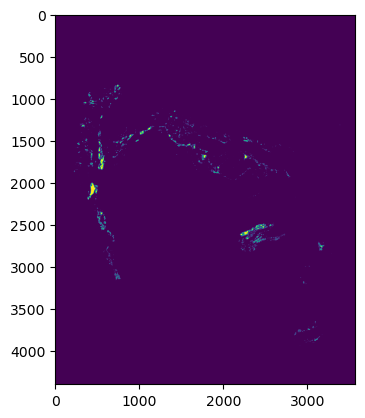

<Axes: >

In [43]:
show(AreaSum)